In [1]:
"""
Title: Full Preprocessing, Feature Engineering, and Modeling Pipeline for Hospital Bed Utilization

Description:
This script performs the complete data pipeline for analyzing and modeling hospital bed utilization rates
using social determinants of health (SDOH) and geographic access features. The workflow includes:

1. Data Loading and Initial Exploration
2. Preprocessing and Filtering (e.g., region/state exclusions, missing data handling)
3. Feature Engineering:
   - One-hot encoding of Region
   - Target encoding of State
   - Binary encoding and KNN imputation for Is_Metro_Micro
4. Data Standardization
5. Train-Test Splitting using calculated ratio
6. Export of final datasets:
   - Full dataset with preserved missing targets
   - Modeling-only dataset (no missing targets)
7. Normality Assessment (Shapiro-Wilk, Q-Q Plot, KDE)
8. Box-Cox transformation for target normalization (optional step)
9. Predictive Modeling:
   - Ridge and Lasso Regression (pre- and post-transformation)
   - Residual analysis and diagnostic testing (Shapiro-Wilk, Breusch-Pagan)
10. Export of modeling-ready files and visualizations

Inputs:
- 'MERGED_SDOH_PLUS_UTIL_24_RenamedColumns.csv': Raw merged dataset with renamed variables

Outputs:
- 'final_full_dataset_with_preserved_missing_targets.xlsx': Full dataset with encoded, imputed values
- 'modeling_dataset_only.xlsx': Cleaned and ready dataset for modeling without missing targets

Note:
- Target variable: 'Bed_util_ratio'
- Special handling applied to: 'Is_Metro_Micro', 'State', and 'Region'
- Box-Cox applied to transform target variable when required
- Residual diagnostics included to evaluate assumptions of regression models
"""



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading and Initial Exploration

In [2]:
df = pd.read_csv('/content/MERGED_SDOH_PLUS_UTIL_24_RenamedColumns.csv')
df.head()

,CountyFIPS,State,County,Region,Pct_renter_occupied,Distance_to_medsurge_icu,Pct_renter_cost_50pct_plus,Pct_renter_cost_30pct_plus,Total_population_poverty,Pct_owner_cost_30plus,...,Pct_age_65plus,Pct_homes_no_vehicle,Pct_public_transit,Pct_single_parent,Pct_hh_no_internet,Distance_to_ED,Pct_mobile_homes,Pct_disabled,Is_Metro_Micro,Bed_util_ratio
0,1001,Alabama,Autauga County,South,24.941176,5.352941,28.352941,43.176470,55181.0,19.588235,...,15.352941,5.294117,0.470588,27.411764,82.352941,5.294117,17.882352,17.470588,1.0,0.378106
1,1003,Alabama,Baldwin County,South,22.727272,7.500000,19.545454,43.795454,215170.0,20.227272,...,21.681818,3.090909,0.045454,20.386363,83.204545,6.409090,12.159090,13.977272,1.0,0.504948
2,1005,Alabama,Barbour County,South,37.888888,8.666666,20.666666,46.222222,22070.0,16.333333,...,19.777777,11.888888,0.111111,47.777777,65.000000,8.666666,27.888888,19.111111,1.0,0.284690
3,1007,Alabama,Bibb County,South,24.500000,21.250000,27.750000,49.625000,20748.0,13.250000,...,16.250000,5.750000,0.000000,31.750000,74.875000,8.500000,33.250000,18.000000,1.0,0.286999
4,1009,Alabama,Blount County,South,24.062500,9.750000,23.562500,47.875000,57127.0,15.187500,...,18.500000,5.375000,0.125000,26.062500,80.187500,9.625000,25.500000,15.000000,1.0,0.304907


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CountyFIPS                  3239 non-null   int64  
 1   State                       3239 non-null   object 
 2   County                      3234 non-null   object 
 3   Region                      3143 non-null   object 
 4   Pct_renter_occupied         3234 non-null   float64
 5   Distance_to_medsurge_icu    3234 non-null   float64
 6   Pct_renter_cost_50pct_plus  3234 non-null   float64
 7   Pct_renter_cost_30pct_plus  3234 non-null   float64
 8   Total_population_poverty    3234 non-null   float64
 9   Pct_owner_cost_30plus       3234 non-null   float64
 10  Population_density          3234 non-null   float64
 11  Land_area_sqmi              3234 non-null   float64
 12  Median_hh_income            3234 non-null   float64
 13  Pct_hh_65_alone             3234 

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CountyFIPS,3239.0,31504.662550,16462.990939,1001.000000,19032.000000,30033.000000,46126.000000,7.803000e+04
Pct_renter_occupied,3234.0,26.781928,9.633306,0.000000,21.333333,26.000000,31.798276,8.200000e+01
Distance_to_medsurge_icu,3234.0,12.573051,17.665270,0.000000,4.666666,7.300000,16.500000,4.870000e+02
Pct_renter_cost_50pct_plus,3234.0,18.632206,7.791009,0.000000,14.283193,18.836021,23.285714,7.500000e+01
Pct_renter_cost_30pct_plus,3234.0,39.682482,12.036717,0.000000,34.000000,41.000000,46.761029,1.000000e+02
Total_population_poverty,3234.0,98504.677798,322472.553341,0.000000,9612.250000,23553.000000,63324.000000,9.884138e+06
Pct_owner_cost_30plus,3234.0,17.706173,5.730589,0.000000,14.833333,17.500000,20.698997,4.275000e+01
Population_density,3234.0,891.208574,2798.157565,0.000000,41.525000,209.100000,907.020161,9.038623e+04
Land_area_sqmi,3234.0,289.385427,1296.982616,0.000000,27.857143,72.000000,173.317307,3.639325e+04
Median_hh_income,3234.0,53803.784787,17732.176889,0.000000,44620.500000,52881.500000,61834.750000,1.485230e+05


In [5]:
df.isna().sum()

,0
CountyFIPS,0
State,0
County,5
Region,96
Pct_renter_occupied,5
Distance_to_medsurge_icu,5
Pct_renter_cost_50pct_plus,5
Pct_renter_cost_30pct_plus,5
Total_population_poverty,5
Pct_owner_cost_30plus,5


In [6]:
# Display structure and summary
print(df.shape)
print(df.dtypes.value_counts())

(3239, 24)
float64    20
object      3
int64       1
Name: count, dtype: int64


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CountyFIPS                  3239 non-null   int64  
 1   State                       3239 non-null   object 
 2   County                      3234 non-null   object 
 3   Region                      3143 non-null   object 
 4   Pct_renter_occupied         3234 non-null   float64
 5   Distance_to_medsurge_icu    3234 non-null   float64
 6   Pct_renter_cost_50pct_plus  3234 non-null   float64
 7   Pct_renter_cost_30pct_plus  3234 non-null   float64
 8   Total_population_poverty    3234 non-null   float64
 9   Pct_owner_cost_30plus       3234 non-null   float64
 10  Population_density          3234 non-null   float64
 11  Land_area_sqmi              3234 non-null   float64
 12  Median_hh_income            3234 non-null   float64
 13  Pct_hh_65_alone             3234 

# Final Data Preprocessing and Feature Engineering Pipeline (with One-Hot Encoding, Target Encoding, and KNN Imputation for Is_Metro_Micro Only)

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

# Train-test split calculator
def calcSplitRatio(df, p=None):
    if p is None:
        p = df.shape[1] - 1
    test_N = (1 / np.sqrt(p)) * len(df)
    test_prop = round(test_N / len(df), 2)
    train_prop = 1 - test_prop
    print(f"\nCalculated train/test split: {train_prop:.2f}/{test_prop:.2f}")
    return train_prop

# Filter and split full dataset
df_cleaned = df.dropna(subset=["Region"])
df_cleaned = df_cleaned[df_cleaned["State"] != "District of Columbia"]

predictor_cols = [col for col in df_cleaned.columns if col not in ["Bed_util_ratio", "Is_Metro_Micro"]]
df_cleaned = df_cleaned.dropna(subset=predictor_cols)

# Split into: with-target (for modeling) vs. missing-target (for our preservation)
df_modeling = df_cleaned[df_cleaned["Bed_util_ratio"].notnull()].copy()
df_missing_target = df_cleaned[df_cleaned["Bed_util_ratio"].isnull()].copy()

print(f"Modeling dataset shape (non-missing target): {df_modeling.shape}")
print(f"Rows with missing Bed_util_ratio preserved separately: {df_missing_target.shape}")

# Train-test split
X = df_modeling.drop(columns=["Bed_util_ratio"])
y = df_modeling["Bed_util_ratio"]
split_ratio = calcSplitRatio(df_modeling)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split_ratio, random_state=42)

# Encoding
# Binary encode Is_Metro_Micro
for subset in [X_train, X_test]:
    subset["Is_Metro_Micro"] = subset["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})

# Target encode State
state_target_mean = y_train.groupby(X_train["State"]).mean()
X_train["state_encoded"] = X_train["State"].map(state_target_mean)
X_test["state_encoded"] = X_test["State"].map(state_target_mean)

# One-hot encode Region
X_train = pd.get_dummies(X_train, columns=["Region"], prefix="Region", drop_first=True)
X_test = pd.get_dummies(X_test, columns=["Region"], prefix="Region", drop_first=True)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Drop unused columns
X_train = X_train.drop(columns=["CountyFIPS", "County", "State"])
X_test = X_test.drop(columns=["CountyFIPS", "County", "State"])

# Scaling + Imputation for Is_Metro_Micro only
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# KNN Impute Is_Metro_Micro
knn = KNNImputer(n_neighbors=5)
X_train_scaled["Is_Metro_Micro"] = knn.fit_transform(X_train_scaled[["Is_Metro_Micro"]])
X_test_scaled["Is_Metro_Micro"] = knn.transform(X_test_scaled[["Is_Metro_Micro"]])

# -----------------
# Above
# Reattach target
train_final = X_train_scaled.copy()
train_final["Bed_util_ratio"] = y_train
test_final = X_test_scaled.copy()
test_final["Bed_util_ratio"] = y_test

# Combine for modeling dataset
df_model_imputed = pd.concat([train_final, test_final]).sort_index()
df_model_imputed["Is_Metro_Micro"] = (df_model_imputed["Is_Metro_Micro"] >= 0.5).astype(int)

print("\nModeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.")
print(df_model_imputed.head())

# Append back missing-target rows for full dataset view
# We just encode + scale them similarly (skip splitting)
df_missing_target_encoded = df_missing_target.copy()

# Binary encode Is_Metro_Micro
df_missing_target_encoded["Is_Metro_Micro"] = df_missing_target_encoded["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})

# Target encode State using same map
df_missing_target_encoded["state_encoded"] = df_missing_target_encoded["State"].map(state_target_mean)

# One-hot encode Region and align
df_missing_target_encoded = pd.get_dummies(df_missing_target_encoded, columns=["Region"], prefix="Region", drop_first=True)
df_missing_target_encoded = df_missing_target_encoded.reindex(columns=X_train.columns.union(["state_encoded", "Is_Metro_Micro"]), fill_value=0)

# Standardize numeric
df_missing_scaled = df_missing_target_encoded.copy()

# Ensure we only transform the same columns used during fit
# reorder + subset
df_missing_scaled = df_missing_scaled[X_train.columns]
df_missing_scaled = pd.DataFrame(scaler.transform(df_missing_scaled), columns=X_train.columns, index=df_missing_scaled.index)


# Impute Is_Metro_Micro
df_missing_scaled["Is_Metro_Micro"] = knn.transform(df_missing_scaled[["Is_Metro_Micro"]])
df_missing_scaled["Is_Metro_Micro"] = (df_missing_scaled["Is_Metro_Micro"] >= 0.5).astype(int)

# Add placeholder Bed_util_ratio = NaN
df_missing_scaled["Bed_util_ratio"] = np.nan

# Final full dataset
df_final_full = pd.concat([df_model_imputed, df_missing_scaled], axis=0).sort_index()
print(f"\nFull dataset shape after re-integration: {df_final_full.shape}")
print(df_final_full.head())

# Export if needed
df_final_full.to_excel("final_full_dataset_with_preserved_missing_targets.xlsx", index=False)
print("\nExported full dataset with missing targets preserved.")

# Export Modeling-Only Dataset (no missing Bed_util_ratio)
df_model_imputed.to_excel("modeling_dataset_only.xlsx", index=False)
print("Exported: modeling_dataset_only.xlsx")


Modeling dataset shape (non-missing target): (2391, 24)
Rows with missing Bed_util_ratio preserved separately: (751, 24)

Calculated train/test split: 0.79/0.21

Modeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.
   Pct_renter_occupied  Distance_to_medsurge_icu  Pct_renter_cost_50pct_plus  \
0            -0.427518                 -0.471124                    1.383576   
1            -0.701126                 -0.248484                    0.013291   
2             1.172644                 -0.127506                    0.187731   
3            -0.482041                  1.177327                    1.289770   
4            -0.536110                 -0.015169                    0.638270   

   Pct_renter_cost_30pct_plus  Total_population_poverty  \
0                    0.231582                 -0.186281   
1                    0.301195                  0.256987   
2                    0.574114                 -0.278018   
3                    0.956798         

In [9]:
X_train_scaled.isnull().sum()

,0
Pct_renter_occupied,0
Distance_to_medsurge_icu,0
Pct_renter_cost_50pct_plus,0
Pct_renter_cost_30pct_plus,0
Total_population_poverty,0
Pct_owner_cost_30plus,0
Population_density,0
Land_area_sqmi,0
Median_hh_income,0
Pct_hh_65_alone,0


In [10]:
X_test_scaled.isnull().sum()

,0
Pct_renter_occupied,0
Distance_to_medsurge_icu,0
Pct_renter_cost_50pct_plus,0
Pct_renter_cost_30pct_plus,0
Total_population_poverty,0
Pct_owner_cost_30plus,0
Population_density,0
Land_area_sqmi,0
Median_hh_income,0
Pct_hh_65_alone,0


In [11]:
len(X_train_scaled), len(X_test_scaled)

(1888, 503)

# Histogram of Bed_util_ratio - Train vs Test (No Imputation)

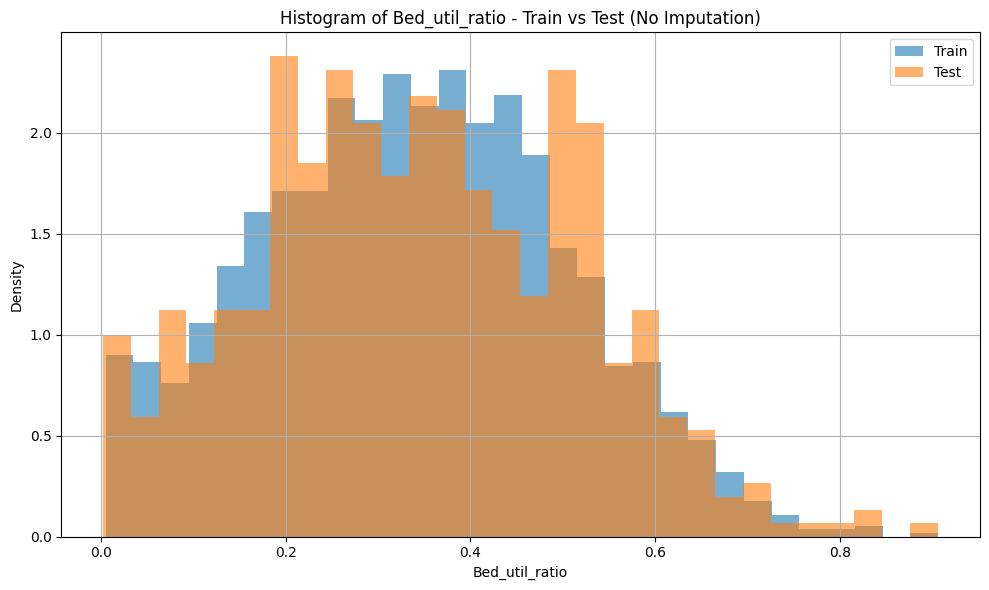

In [12]:
# === Histogram of Bed_util_ratio - Train vs Test (No Imputation) ===
plt.figure(figsize=(10, 6))
plt.hist(train_final["Bed_util_ratio"], bins=30, alpha=0.6, label="Train", density=True)
plt.hist(test_final["Bed_util_ratio"], bins=30, alpha=0.6, label="Test", density=True)
plt.title("Histogram of Bed_util_ratio - Train vs Test (No Imputation)")
plt.xlabel("Bed_util_ratio")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# BarPlot - Imputation Comparison for Is_Metro_Micro

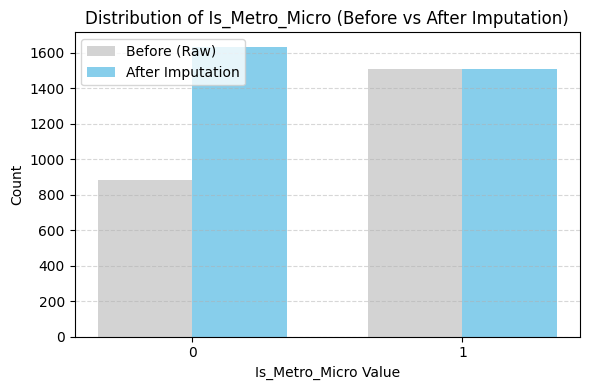

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Before imputation: include NaNs
before = df_cleaned["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan}).value_counts(dropna=False)
before.index = before.index.astype("object")  # so NaN label is retained

# After imputation: should be only 0 and 1
after = df_final_full["Is_Metro_Micro"].value_counts()

# Align both to 0 and 1 only (for bar chart)
x_labels = [0, 1]
before_aligned = [before.get(0, 0), before.get(1, 0)]
after_aligned = [after.get(0, 0), after.get(1, 0)]

# Plot
bar_width = 0.35
x = np.arange(len(x_labels))

plt.figure(figsize=(6, 4))
plt.bar(x - bar_width/2, before_aligned, width=bar_width, label="Before (Raw)", color="lightgray")
plt.bar(x + bar_width/2, after_aligned, width=bar_width, label="After Imputation", color="skyblue")

plt.xticks(ticks=x, labels=["0", "1"])
plt.xlabel("Is_Metro_Micro Value")
plt.ylabel("Count")
plt.title("Distribution of Is_Metro_Micro (Before vs After Imputation)")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Shapiro-Wilk W Statistic for Bed_util_ratio

In [14]:
from scipy.stats import shapiro

# Run only on non-null values
target_values = df_final_full["Bed_util_ratio"].dropna()

# Perform Shapiro-Wilk test
stat, p = shapiro(target_values)

print("Shapiro-Wilk W Statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("Target appears normally distributed (fail to reject H0)")
else:
    print("Target likely not normally distributed (reject H0)")


Shapiro-Wilk W Statistic: 0.9919237932068726
p-value: 2.821064526072581e-10
Target likely not normally distributed (reject H0)


In [15]:
Shapiro_Result = """We conducted a Shapiro-Wilk test on Bed_util_ratio to assess normality. \nThe resulting W statistic was 0.992 with a p-value < 0.001, indicating the distribution is not normal. \nThis insight may inform downstream modeling choices (e.g., transformation before regularized regression). \nSince our primary modeling approach includes methods that do not assume normality (e.g., tree-based or clustering models), \nwe retained the raw distribution of the target for now."""
print(Shapiro_Result)

We conducted a Shapiro-Wilk test on Bed_util_ratio to assess normality. 
The resulting W statistic was 0.992 with a p-value < 0.001, indicating the distribution is not normal. 
This insight may inform downstream modeling choices (e.g., transformation before regularized regression). 
Since our primary modeling approach includes methods that do not assume normality (e.g., tree-based or clustering models), 
we retained the raw distribution of the target for now.


# Distribution of Bed_Util_Ratio w/ KDE

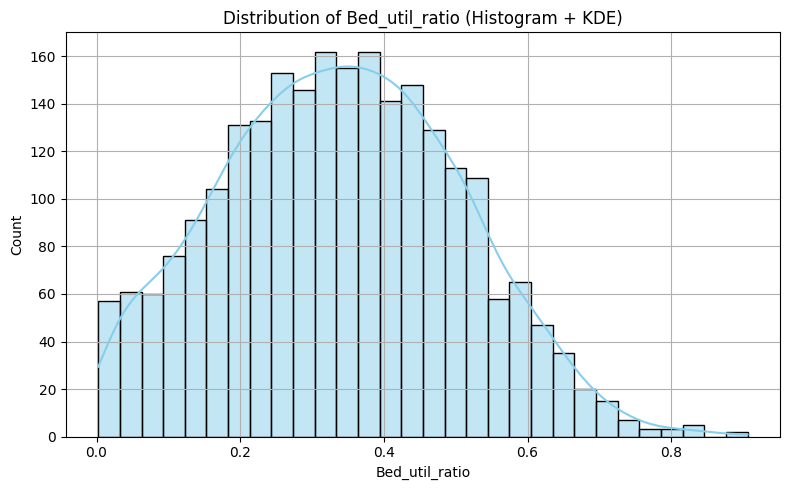

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop missing target values
bed_util_values = df_final_full["Bed_util_ratio"].dropna()

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(bed_util_values, kde=True, bins=30, color="skyblue")
plt.title("Distribution of Bed_util_ratio (Histogram + KDE)")
plt.xlabel("Bed_util_ratio")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


# Q-Q Plot for Normality Check

<Figure size 600x600 with 0 Axes>

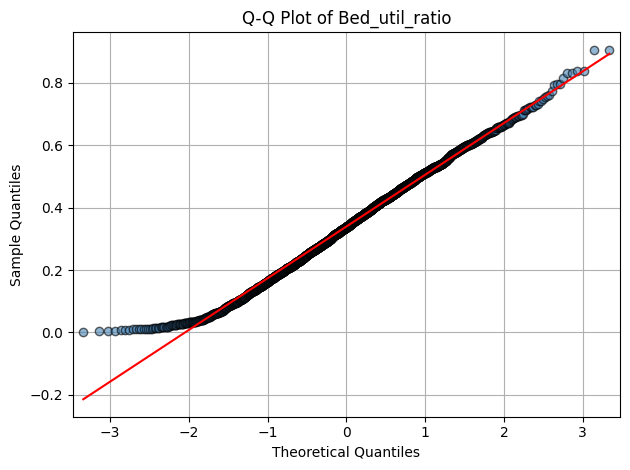

In [17]:
import statsmodels.api as sm
import scipy.stats as stats

# Drop missing target values
bed_util_values = df_final_full["Bed_util_ratio"].dropna()

# QQ plot
plt.figure(figsize=(6, 6))
sm.qqplot(bed_util_values, line="s", markerfacecolor='steelblue', markeredgecolor='black', alpha=0.6)
plt.title("Q-Q Plot of Bed_util_ratio")
plt.grid(True)
plt.tight_layout()
plt.show()


# Post-Transformation Analysis

# Box-Cox Normalization + (Shapiro-Wilk Test & Bed_util_ratio)

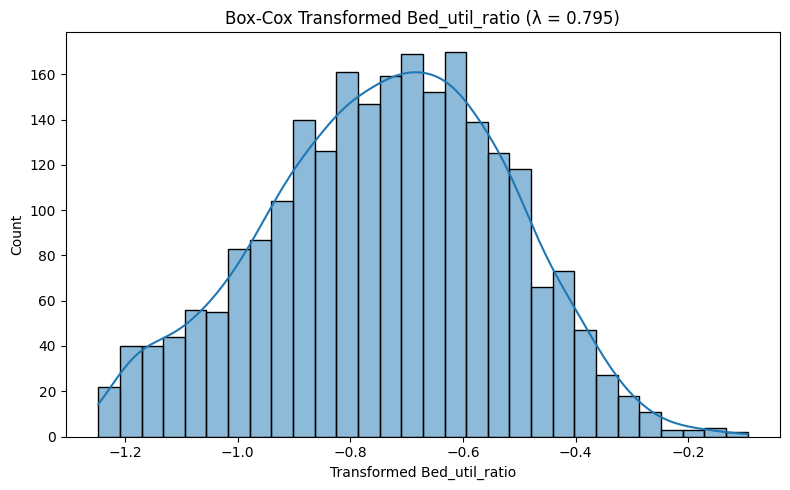


Shapiro-Wilk Test (after Box-Cox):
W statistic: 0.99314
p-value:     3.66059e-09
Target likely not normally distributed (reject H0)
Modeling dataset shape (non-missing target): (2391, 24)
Rows with missing Bed_util_ratio preserved separately: (751, 24)

Calculated train/test split: 0.79/0.21

Modeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.
   Pct_renter_occupied  Distance_to_medsurge_icu  Pct_renter_cost_50pct_plus  \
0            -0.427518                 -0.471124                    1.383576   
1            -0.701126                 -0.248484                    0.013291   
2             1.172644                 -0.127506                    0.187731   
3            -0.482041                  1.177327                    1.289770   
4            -0.536110                 -0.015169                    0.638270   

   Pct_renter_cost_30pct_plus  Total_population_poverty  \
0                    0.231582                 -0.186281   
1                    0.

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

# Train-test split calculator
def calcSplitRatio(df, p=None):
    if p is None:
        p = df.shape[1] - 1
    test_N = (1 / np.sqrt(p)) * len(df)
    test_prop = round(test_N / len(df), 2)
    train_prop = 1 - test_prop
    print(f"\nCalculated train/test split: {train_prop:.2f}/{test_prop:.2f}")
    return train_prop

# Filter and split full dataset
df_cleaned = df.dropna(subset=["Region"])
df_cleaned = df_cleaned[df_cleaned["State"] != "District of Columbia"]

predictor_cols = [col for col in df_cleaned.columns if col not in ["Bed_util_ratio", "Is_Metro_Micro"]]
df_cleaned = df_cleaned.dropna(subset=predictor_cols)

# Split into: with-target (for modeling) vs. missing-target (for our preservation)
df_modeling = df_cleaned[df_cleaned["Bed_util_ratio"].notnull()].copy()
df_missing_target = df_cleaned[df_cleaned["Bed_util_ratio"].isnull()].copy()

# --------------------------------------------------------------
# ADDED NORMALIZATION FOR TARGET (BOX-COX)
from scipy.stats import boxcox, shapiro
import seaborn as sns

# Drop NaNs from target
target_raw = df_modeling["Bed_util_ratio"].dropna()

# Check for any values ≤ 0
if (target_raw <= 0).any():
    print("Box-Cox requires all values > 0 — applying small offset")
    target_shifted = target_raw + 1e-4
else:
    target_shifted = target_raw.copy()

# Box-Cox Transformation
target_bc, lambda_bc = boxcox(target_shifted)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(target_bc, bins=30, kde=True)
plt.title(f"Box-Cox Transformed Bed_util_ratio (λ = {lambda_bc:.3f})")
plt.xlabel("Transformed Bed_util_ratio")
plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
stat, p = shapiro(target_bc)
print("\nShapiro-Wilk Test (after Box-Cox):")
print(f"W statistic: {stat:.5f}")
print(f"p-value:     {p:.5e}")

if p > 0.05:
    print("Target appears normally distributed (fail to reject H0)")
else:
    print("Target likely not normally distributed (reject H0)")

# ------------------------------------------------------------------------

print(f"Modeling dataset shape (non-missing target): {df_modeling.shape}")
print(f"Rows with missing Bed_util_ratio preserved separately: {df_missing_target.shape}")

# Train-test split
X = df_modeling.drop(columns=["Bed_util_ratio"])
y = df_modeling["Bed_util_ratio"]
split_ratio = calcSplitRatio(df_modeling)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split_ratio, random_state=42)

# Encoding
# Binary encode Is_Metro_Micro
for subset in [X_train, X_test]:
    subset["Is_Metro_Micro"] = subset["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})

# Target encode State
state_target_mean = y_train.groupby(X_train["State"]).mean()
X_train["state_encoded"] = X_train["State"].map(state_target_mean)
X_test["state_encoded"] = X_test["State"].map(state_target_mean)

# One-hot encode Region
X_train = pd.get_dummies(X_train, columns=["Region"], prefix="Region", drop_first=True)
X_test = pd.get_dummies(X_test, columns=["Region"], prefix="Region", drop_first=True)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Drop unused columns
X_train = X_train.drop(columns=["CountyFIPS", "County", "State"])
X_test = X_test.drop(columns=["CountyFIPS", "County", "State"])

# Scaling + Imputation for Is_Metro_Micro only
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# KNN Impute Is_Metro_Micro
knn = KNNImputer(n_neighbors=5)
X_train_scaled["Is_Metro_Micro"] = knn.fit_transform(X_train_scaled[["Is_Metro_Micro"]])
X_test_scaled["Is_Metro_Micro"] = knn.transform(X_test_scaled[["Is_Metro_Micro"]])

# Reattach target
train_final = X_train_scaled.copy()
train_final["Bed_util_ratio"] = y_train
test_final = X_test_scaled.copy()
test_final["Bed_util_ratio"] = y_test

# Combine for modeling dataset
df_model_imputed = pd.concat([train_final, test_final]).sort_index()
df_model_imputed["Is_Metro_Micro"] = (df_model_imputed["Is_Metro_Micro"] >= 0.5).astype(int)

print("\nModeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.")
print(df_model_imputed.head())

# Append back missing-target rows for full dataset view
# We just encode + scale them similarly (skip splitting)
df_missing_target_encoded = df_missing_target.copy()

# Binary encode Is_Metro_Micro
df_missing_target_encoded["Is_Metro_Micro"] = df_missing_target_encoded["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})

# Target encode State using same map
df_missing_target_encoded["state_encoded"] = df_missing_target_encoded["State"].map(state_target_mean)

# One-hot encode Region and align
df_missing_target_encoded = pd.get_dummies(df_missing_target_encoded, columns=["Region"], prefix="Region", drop_first=True)
df_missing_target_encoded = df_missing_target_encoded.reindex(columns=X_train.columns.union(["state_encoded", "Is_Metro_Micro"]), fill_value=0)

# Standardize numeric
df_missing_scaled = df_missing_target_encoded.copy()

# Ensure we only transform the same columns used during fit
# reorder + subset
df_missing_scaled = df_missing_scaled[X_train.columns]
df_missing_scaled = pd.DataFrame(scaler.transform(df_missing_scaled), columns=X_train.columns, index=df_missing_scaled.index)


# Impute Is_Metro_Micro
df_missing_scaled["Is_Metro_Micro"] = knn.transform(df_missing_scaled[["Is_Metro_Micro"]])
df_missing_scaled["Is_Metro_Micro"] = (df_missing_scaled["Is_Metro_Micro"] >= 0.5).astype(int)

# Add placeholder Bed_util_ratio = NaN
df_missing_scaled["Bed_util_ratio"] = np.nan

# Final full dataset
df_final_full = pd.concat([df_model_imputed, df_missing_scaled], axis=0).sort_index()
print(f"\nFull dataset shape after re-integration: {df_final_full.shape}")
print(df_final_full.head())

# Export if needed
df_final_full.to_excel("final_full_dataset_with_preserved_missing_targets.xlsx", index=False)
print("\nExported full dataset with missing targets preserved.")

# Export Modeling-Only Dataset (no missing Bed_util_ratio)
df_model_imputed.to_excel("modeling_dataset_only.xlsx", index=False)
print("Exported: modeling_dataset_only.xlsx")


# Lasso & Ridge Modeling with Shapiro-Wilk Residual Analysis (Pre-Transformation)


Ridge Regression Results:
Best alpha: 141.7474
Test RMSE: 0.1427
Test R²: 0.3226

Shapiro-Wilk Test (Ridge Residuals):
W statistic: 0.990038
p-value: 0.002488
Residuals likely NOT normal

Lasso Regression Results:
Best alpha: 0.0031
Test RMSE: 0.1435
Test R²: 0.3144

Shapiro-Wilk Test (Lasso Residuals):
W statistic: 0.990690
p-value: 0.004069
Residuals likely NOT normal


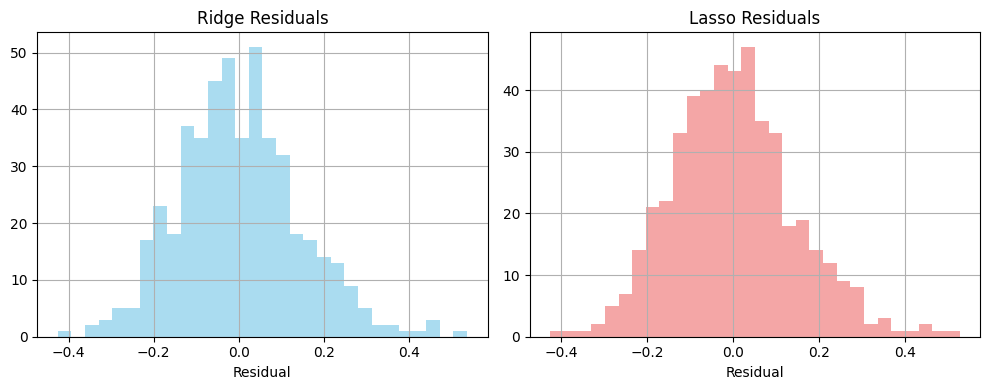

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Step 1: Load your preprocessed dataset
file_path = "modeling_dataset_only.xlsx"
df = pd.read_excel(file_path)

# Step 2: Separate features and target
X = df.drop(columns=["Bed_util_ratio"])
y = df["Bed_util_ratio"]

# Step 3: Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Fit Ridge regression with cross-validation
ridge_alphas = np.logspace(-3, 3, 100)
ridge = RidgeCV(alphas=ridge_alphas, cv=5)
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)
ridge_residuals = y_test - ridge_preds

print("\nRidge Regression Results:")
print(f"Best alpha: {ridge.alpha_:.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, ridge_preds)):.4f}")
print(f"Test R²: {r2_score(y_test, ridge_preds):.4f}")

# Shapiro-Wilk test on residuals
stat_ridge, p_ridge = shapiro(ridge_residuals)
print(f"\nShapiro-Wilk Test (Ridge Residuals):")
print(f"W statistic: {stat_ridge:.6f}")
print(f"p-value: {p_ridge:.6f}")
print("Residuals likely normal" if p_ridge > 0.05 else "Residuals likely NOT normal")

# Step 6: Fit Lasso regression with cross-validation
lasso_alphas = np.logspace(-3, 3, 100)
lasso = LassoCV(alphas=lasso_alphas, cv=5, max_iter=5000)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)
lasso_residuals = y_test - lasso_preds

print("\nLasso Regression Results:")
print(f"Best alpha: {lasso.alpha_:.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, lasso_preds)):.4f}")
print(f"Test R²: {r2_score(y_test, lasso_preds):.4f}")

# Shapiro-Wilk test on residuals
stat_lasso, p_lasso = shapiro(lasso_residuals)
print(f"\nShapiro-Wilk Test (Lasso Residuals):")
print(f"W statistic: {stat_lasso:.6f}")
print(f"p-value: {p_lasso:.6f}")
print("Residuals likely normal" if p_lasso > 0.05 else "Residuals likely NOT normal")

# Optional: Plot Residuals
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(ridge_residuals, bins=30, alpha=0.7, color='skyblue')
plt.title("Ridge Residuals")
plt.xlabel("Residual")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(lasso_residuals, bins=30, alpha=0.7, color='lightcoral')
plt.title("Lasso Residuals")
plt.xlabel("Residual")
plt.grid(True)

plt.tight_layout()
plt.show()


# Box-Cox + Ridge/Lasso Regression + Residual Normality Check

Box-Cox Lambda: 0.7952

Ridge Regression Results:
Best alpha: 162.9751
Test RMSE: 0.1826
Test R²: 0.3219

Shapiro-Wilk Test (Ridge Residuals):
W statistic: 0.995824
p-value:     0.234900
Residuals appear normal

Lasso Regression Results:
Best alpha: 0.0013
Test RMSE: 0.1829
Test R²: 0.3199

Shapiro-Wilk Test (Lasso Residuals):
W statistic: 0.996209
p-value:     0.311902
Residuals appear normal


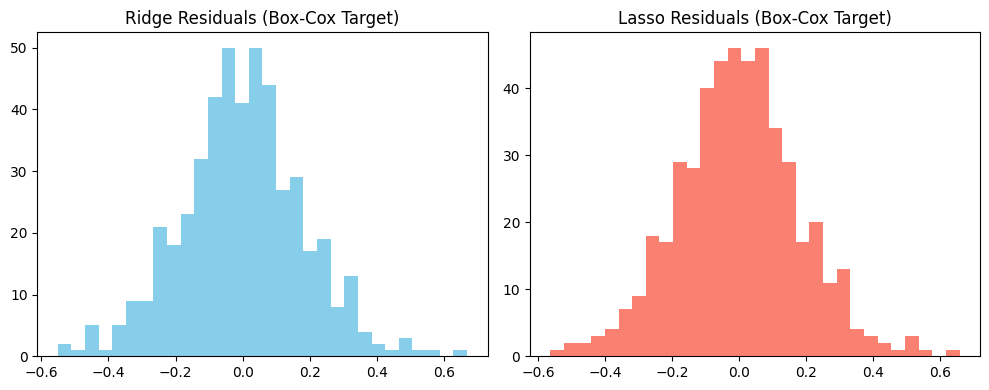


Inverse Transformed RMSEs:
Ridge RMSE (original scale): 0.1433
Lasso RMSE (original scale): 0.1435


In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox, shapiro
import matplotlib.pyplot as plt

# Load data
df = df_model_imputed.copy()

# Split predictors and target
X = df.drop(columns=["Bed_util_ratio"])
y = df["Bed_util_ratio"].copy()

# Apply Box-Cox transformation
# Box-Cox requires all positive values
if (y <= 0).any():
    y += abs(y.min()) + 0.01

y_transformed, lmbda = boxcox(y)
print(f"Box-Cox Lambda: {lmbda:.4f}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

# Scale predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge Regression
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)
residuals_ridge = y_test - y_pred_ridge

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

# Ridge Residual Normality
stat_ridge, p_ridge = shapiro(residuals_ridge)

print("\nRidge Regression Results:")
print(f"Best alpha: {ridge.alpha_:.4f}")
print(f"Test RMSE: {rmse_ridge:.4f}")
print(f"Test R²: {r2_ridge:.4f}")
print("\nShapiro-Wilk Test (Ridge Residuals):")
print(f"W statistic: {stat_ridge:.6f}")
print(f"p-value:     {p_ridge:.6f}")
print("Residuals appear normal" if p_ridge > 0.05 else "Residuals likely NOT normal")

# Lasso Regression
lasso = LassoCV(alphas=np.logspace(-5, 1, 100), cv=5, max_iter=10000)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)
residuals_lasso = y_test - y_pred_lasso

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

# Lasso Residual Normality
stat_lasso, p_lasso = shapiro(residuals_lasso)

print("\nLasso Regression Results:")
print(f"Best alpha: {lasso.alpha_:.4f}")
print(f"Test RMSE: {rmse_lasso:.4f}")
print(f"Test R²: {r2_lasso:.4f}")
print("\nShapiro-Wilk Test (Lasso Residuals):")
print(f"W statistic: {stat_lasso:.6f}")
print(f"p-value:     {p_lasso:.6f}")
print("Residuals appear normal" if p_lasso > 0.05 else "Residuals likely NOT normal")

# Plot residual histograms
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(residuals_ridge, bins=30, color="skyblue")
plt.title("Ridge Residuals (Box-Cox Target)")

plt.subplot(1, 2, 2)
plt.hist(residuals_lasso, bins=30, color="salmon")
plt.title("Lasso Residuals (Box-Cox Target)")
plt.tight_layout()
plt.show()

# --------------- Inverse the Transormation with Box-Cox --------------------

from scipy.special import inv_boxcox

# Inverse transform predicted values
y_pred_ridge = inv_boxcox(y_pred_ridge, lmbda)
y_pred_lasso = inv_boxcox(y_pred_lasso, lmbda)

# Also inverse y_test for real-world comparison
y_test = inv_boxcox(y_test, lmbda, )

# Compare original RMSE on untransformed scale
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("\nInverse Transformed RMSEs:")
print(f"Ridge RMSE (original scale): {rmse_ridge:.4f}")
print(f"Lasso RMSE (original scale): {rmse_lasso:.4f}")

# Homoscedasticity Assessment (Residuals vs Predicted Values)

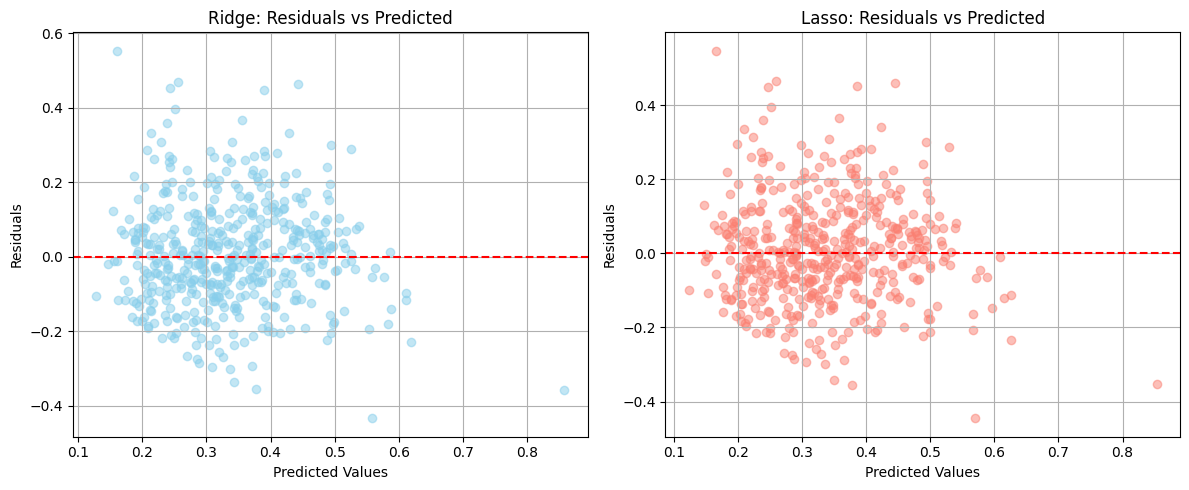

In [21]:
import matplotlib.pyplot as plt

# Recalculate residuals after inverse Box-Cox (if not already done)
residuals_ridge = y_test - y_pred_ridge
residuals_lasso = y_test - y_pred_lasso

plt.figure(figsize=(12, 5))

# Ridge plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.5, color="skyblue")
plt.axhline(0, color='red', linestyle='--')
plt.title("Ridge: Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)

# Lasso plot
plt.subplot(1, 2, 2)
plt.scatter(y_pred_lasso, residuals_lasso, alpha=0.5, color="salmon")
plt.axhline(0, color='red', linestyle='--')
plt.title("Lasso: Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)

plt.tight_layout()
plt.show()


# Heteroscedasticity Check via Breusch-Pagan Test (Residual Variance Test)

In [22]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Add constant to X_test for the BP test
X_test_const = sm.add_constant(X_test)

# Breusch-Pagan test for Ridge
bp_ridge = het_breuschpagan(residuals_ridge, X_test_const)
lm_stat_ridge, lm_p_ridge, f_stat_ridge, f_p_ridge = bp_ridge

print("Breusch-Pagan Test (Ridge Residuals):")
print(f"LM Statistic: {lm_stat_ridge:.3f}, p-value: {lm_p_ridge:.4f}")
print(f"F Statistic:  {f_stat_ridge:.3f}, p-value: {f_p_ridge:.4f}")
print("→ Heteroscedasticity detected!" if lm_p_ridge < 0.05 else "→ Homoscedasticity likely.")

# Breusch-Pagan test for Lasso
bp_lasso = het_breuschpagan(residuals_lasso, X_test_const)
lm_stat_lasso, lm_p_lasso, f_stat_lasso, f_p_lasso = bp_lasso

print("\nBreusch-Pagan Test (Lasso Residuals):")
print(f"LM Statistic: {lm_stat_lasso:.3f}, p-value: {lm_p_lasso:.4f}")
print(f"F Statistic:  {f_stat_lasso:.3f}, p-value: {f_p_lasso:.4f}")
print("→ Heteroscedasticity detected!" if lm_p_lasso < 0.05 else "→ Homoscedasticity likely.")


Breusch-Pagan Test (Ridge Residuals):
LM Statistic: 52.893, p-value: 0.0004
F Statistic:  2.456, p-value: 0.0002
→ Heteroscedasticity detected!

Breusch-Pagan Test (Lasso Residuals):
LM Statistic: 51.768, p-value: 0.0005
F Statistic:  2.397, p-value: 0.0003
→ Heteroscedasticity detected!


In [23]:
np.isnan(X_test_scaled).sum()

np.int64(0)

# PCA – Dimensionality Reduction & Target Transformation (starting from X_train_scaled)

# J_Started

Original shape (X_train_scaled): (1912, 23)


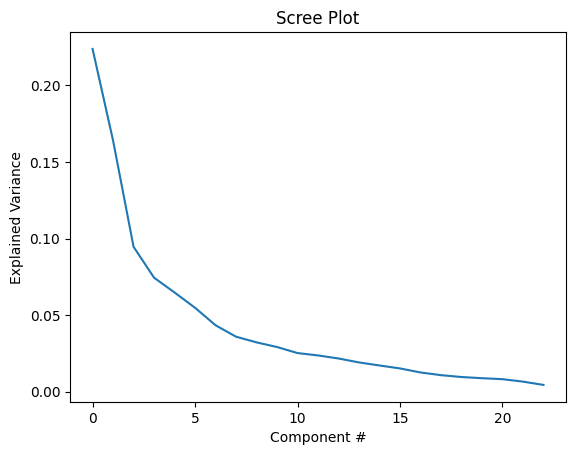

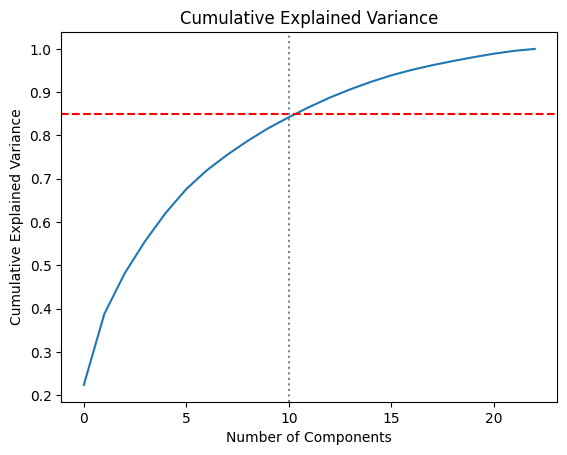

Explained variance ratio for each component
[0.22373655 0.16392636 0.09457926 0.0744292  0.06476568 0.05478189
 0.04338595 0.0359096  0.03221762 0.0291659  0.02523529 0.02368981
 0.02168855 0.01911898 0.01712495 0.01520235 0.01257163 0.01081795
 0.00960049 0.00882577 0.00819176 0.00659331 0.00444116]
Final concatenated shape (train): (1912, 33)
Final concatenated shape (test): (479, 33)


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

principal = PCA()
principal.fit(X_train_scaled)

# Inspect original shape
print("Original shape (X_train_scaled):", X_train_scaled.shape)

explained_variance_ratio = principal.explained_variance_ratio_
# explained variance
plt.plot(explained_variance_ratio)
plt.title('Scree Plot')
plt.xlabel('Component #')
plt.ylabel('Explained Variance')
plt.show()
# cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='--')
plt.axvline(x=10, color='grey', linestyle='dotted')
plt.show()
print("Explained variance ratio for each component")
print(explained_variance_ratio)

"""You are getting the AttributeError: 'numpy.ndarray' object has no attribute
'reset_index' because X_train_scaled and X_test_scaled are likely NumPy arrays,
not Pandas DataFrames. The .reset_index() method is specific to Pandas DataFrames.
To fix this, you need to convert X_train_scaled and X_test_scaled to Pandas DataFrames
before attempting to use .reset_index() on them."""

# start with original set of numeric columns
# project observations onto PCs
latent_features = pd.DataFrame(principal.transform(X_train_scaled))
latent_features_test = pd.DataFrame(principal.transform(X_test_scaled))

# start here - I get errors related to "AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'"
# take first 10 col from latent_features
X_train_PCA = pd.concat([latent_features.iloc[:, 0:10].reset_index(drop=True), pd.DataFrame(X_train_scaled).reset_index(drop=True)], axis=1)

# repeat on test set
X_test_PCA = pd.concat([latent_features_test.iloc[:, 0:10].reset_index(drop=True),
                        pd.DataFrame(X_test_scaled).reset_index(drop=True)], axis=1)

# --- Final Output ---
print("Final concatenated shape (train):", X_train_PCA.shape)
print("Final concatenated shape (test):", X_test_PCA.shape)

# Team Started

Box-Cox Lambda: 1.0043


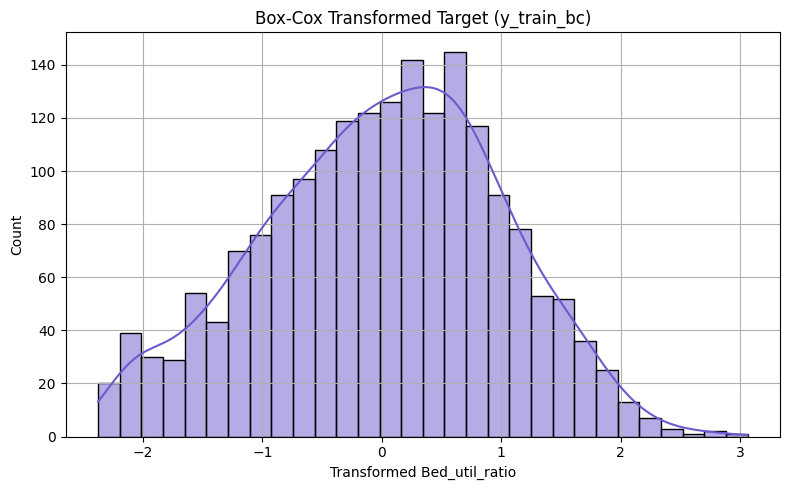

Shapiro-Wilk Test for Normality of Transformed Target:
W = 0.9927, p = 0.0000
Transformed target likely not normal.


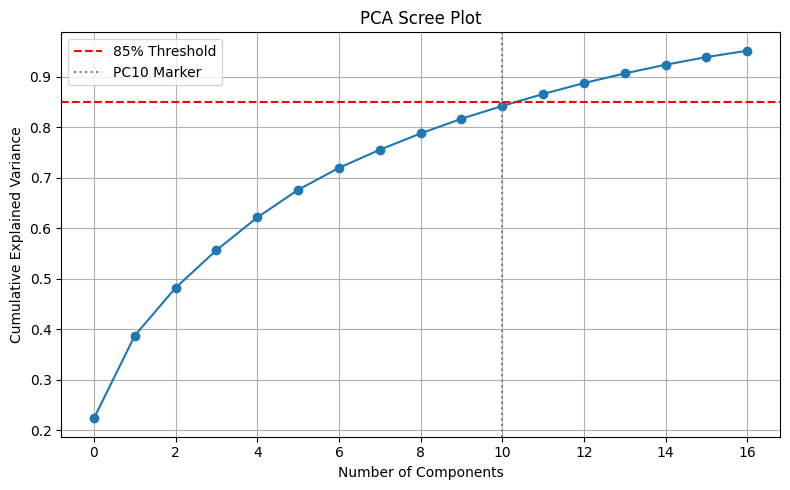

,Component,Explained Variance Ratio,Cumulative Variance
0,PC1,0.223737,0.223737
1,PC2,0.163926,0.387663
2,PC3,0.094579,0.482242
3,PC4,0.074429,0.556671
4,PC5,0.064766,0.621437
5,PC6,0.054782,0.676219
6,PC7,0.043386,0.719605
7,PC8,0.035910,0.755515
8,PC9,0.032218,0.787732
9,PC10,0.029166,0.816898


Original shape (X_train_scaled): (1912, 23)
Reduced shape after PCA (train): (1912, 17)
Reduced shape after PCA (test): (479, 17)


In [25]:
"""
This cell continues from the preprocessing pipeline and assumes the following
variables are already defined:
- X_train_scaled, X_test_scaled: scaled feature sets (with no missing values)
- y_train, y_test: untransformed target values (may include small or non-positive values)

This step performs:
- Box-Cox transformation on the target (Bed_util_ratio) to correct skewness and approximate normality
    - Applies safe shifting for Box-Cox if any values are ≤ 0
    - Includes diagnostic checks: histogram and Shapiro-Wilk test
- Principal Component Analysis (PCA) on the scaled features to reduce dimensionality
    - Retains enough components to explain ≥95% of variance
    - Visualizes cumulative explained variance via a scree plot

Final outputs:
- Transformed target: y_train_bc, y_test_bc
- Reduced feature sets: X_train_pca, X_test_pca
- Diagnostic outputs for lambda, distribution, normality, and variance retention
"""


# --- PCA + Box-Cox Transformation Setup ---

from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from scipy.special import inv_boxcox
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Shift the target if needed (Box-Cox requires strictly positive values)
if (y_train <= 0).any():
    shift_amount = abs(y_train.min()) + 0.01
    y_train_shifted = y_train + shift_amount
    y_test_shifted = y_test + shift_amount
else:
    shift_amount = 0
    y_train_shifted = y_train
    y_test_shifted = y_test

# Apply Box-Cox
pt = PowerTransformer(method='box-cox')
y_train_bc = pt.fit_transform(y_train_shifted.reshape(-1, 1)).flatten()
y_test_bc = pt.transform(y_test_shifted.reshape(-1, 1)).flatten()
lambda_bc = pt.lambdas_[0]

# ----------------------
# Box-Cox Diagnostic Output

print(f"Box-Cox Lambda: {lambda_bc:.4f}")

# Histogram of Box-Cox Transformed Target
plt.figure(figsize=(8, 5))
sns.histplot(y_train_bc, bins=30, kde=True, color='slateblue')
plt.title("Box-Cox Transformed Target (y_train_bc)")
plt.xlabel("Transformed Bed_util_ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

# Shapiro-Wilk Normality Test
from scipy.stats import shapiro

stat_bc, p_bc = shapiro(y_train_bc)
print(f"Shapiro-Wilk Test for Normality of Transformed Target:")
print(f"W = {stat_bc:.4f}, p = {p_bc:.4f}")
if p_bc > 0.05:
    print("Transformed target appears approximately normal.")
else:
    print("Transformed target likely not normal.")

# ----------------------

# PCA on scaled features
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')

plt.axhline(y=0.85, color='r', linestyle='--', label='85% Threshold')
plt.axvline(x=10, color='grey', linestyle='dotted', label='PC10 Marker')

plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# View explained variance (optional)
explained_variance = pd.DataFrame({
    "Component": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    "Explained Variance Ratio": pca.explained_variance_ratio_,
    "Cumulative Variance": np.cumsum(pca.explained_variance_ratio_)
})
display(explained_variance.head(10))

# --- Final Output ---
# Inspect original shape ---
print("Original shape (X_train_scaled):", X_train_scaled.shape)
print("Reduced shape after PCA (train):", X_train_pca.shape)
print("Reduced shape after PCA (test):", X_test_pca.shape)



# SVM Regression + Evaluation (PCA & SVM Combined w/ CV)

Cross-Validated R² (train): 0.3343 ± 0.0406
Test RMSE (Box-Cox): 5.2129
Test MAE (Box-Cox):  5.1675
Test R² (Box-Cox):   -38.5734

Shapiro-Wilk: W = 0.9907, p = 0.0040
Not Normal


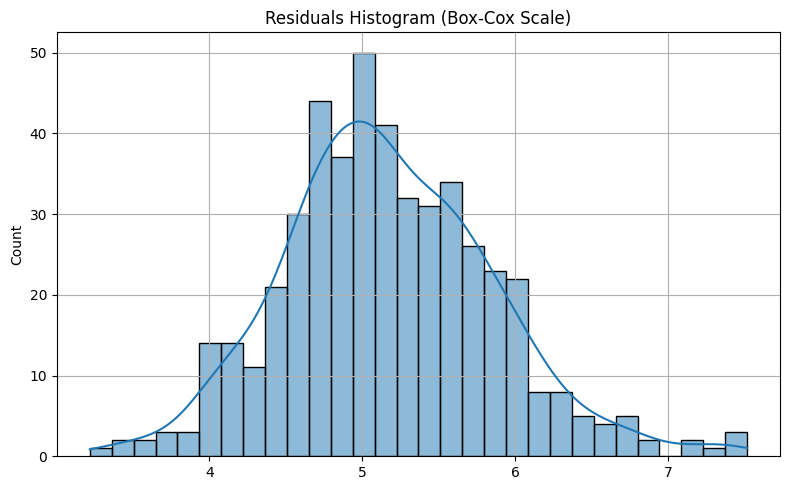

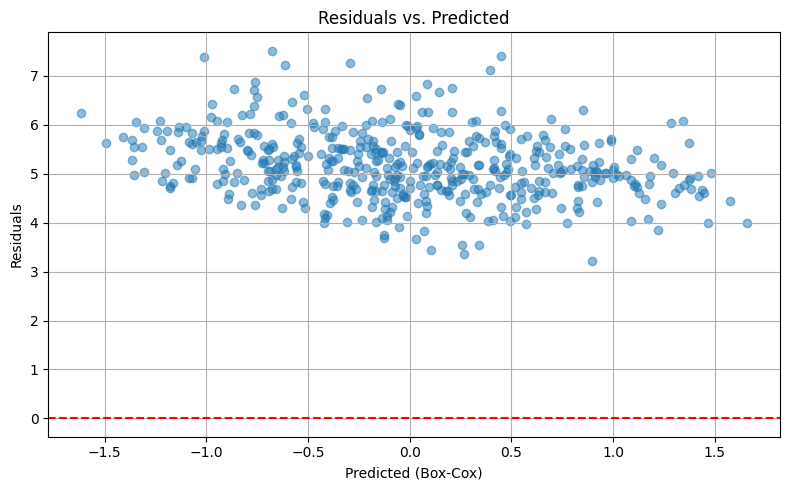


Final RMSE (Original Scale): 5.1546
Dropped 38 NaN predictions from inverse Box-Cox.



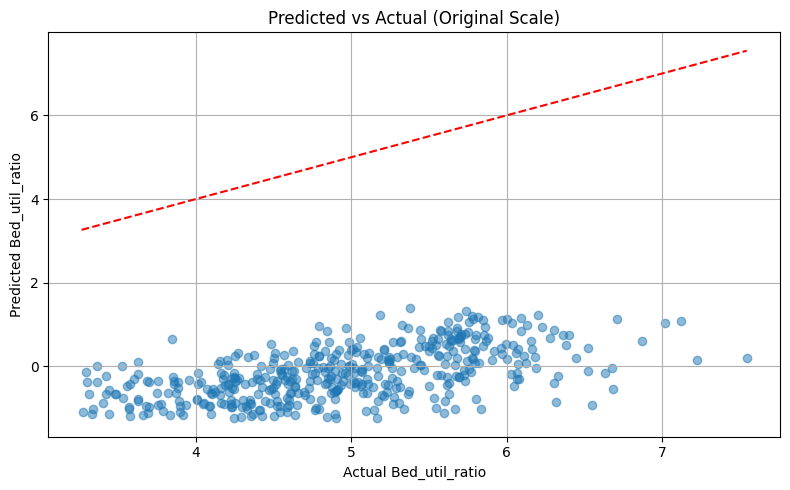

In [26]:
"""
This cell trains and evaluates a Support Vector Regression (SVR) model using
PCA-reduced features and a Box-Cox transformed target.

Workflow Context:
- This step uses PCA-transformed feature sets ('X_train_pca', 'X_test_pca'),
which reduced the original 23 features to 17 components explaining ≥95% of the variance.
- The target variable ('Bed_util_ratio') was transformed using Box-Cox to correct skewness
and approximate normality.
- 'y_train_bc' and 'y_test_bc' are the Box-Cox transformed versions of the target.

What this cell performs:
Fits an SVR model (RBF kernel) **on PCA-reduced input features**
-  Uses 5-fold cross-validation to estimate model R² performance on training data
-  Makes predictions on the Box-Cox-transformed test set ('y_test_bc')
-  Computes key evaluation metrics (RMSE, MAE, R²) **on Box-Cox scale**
-  Performs residual diagnostics, including:
    - Shapiro-Wilk test for residual normality
    - Histogram and residual plots
-  Applies **inverse Box-Cox transformation** to return predictions to original scale
    - Applies inverse Box-Cox transformation to return predictions and test targets to original scale
    - Handles potential NaNs from numerical issues in predictions by filtering invalid values
    - Does not reintroduce original missing values —
    transformations are applied only to the already-clean test set
-  Computes final RMSE in original units and visualizes actual vs. predicted values

Note:
- PCA and SVR together make this a nonlinear regression pipeline with dimensionality reduction.
- The Box-Cox inverse transformation includes safe handling of small/zero values and drops invalid predictions (e.g., due to numerical issues).
"""

# --- SVM Regression + Evaluation ---

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import shapiro

# Fit SVM model
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm, X_train_pca, y_train_bc, cv=cv, scoring='r2')

svm.fit(X_train_pca, y_train_bc)
y_pred_bc = svm.predict(X_test_pca)

# Evaluate on Box-Cox Scale
rmse = np.sqrt(mean_squared_error(y_test_bc, y_pred_bc))
mae = mean_absolute_error(y_test_bc, y_pred_bc)
r2 = r2_score(y_test_bc, y_pred_bc)
print(f"Cross-Validated R² (train): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Test RMSE (Box-Cox): {rmse:.4f}")
print(f"Test MAE (Box-Cox):  {mae:.4f}")
print(f"Test R² (Box-Cox):   {r2:.4f}")

# Residuals
residuals = y_test_bc - y_pred_bc
stat, p_val = shapiro(residuals)
print(f"\nShapiro-Wilk: W = {stat:.4f}, p = {p_val:.4f}")
print("Likely Normal" if p_val > 0.05 else "Not Normal")

# Residual Plot
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Histogram (Box-Cox Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_bc, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted (Box-Cox)")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# Inverse Transform to Original Scale
y_pred_orig = inv_boxcox(y_pred_bc, lambda_bc) - shift_amount
y_test_orig = inv_boxcox(y_test_bc, lambda_bc) - shift_amount

# Handle potential NaNs in y_pred_orig
valid_mask = ~np.isnan(y_pred_orig)
rmse_orig = np.sqrt(mean_squared_error(y_test_orig[valid_mask], y_pred_orig[valid_mask]))
print(f"\nFinal RMSE (Original Scale): {rmse_orig:.4f}")
print(f"Dropped {np.isnan(y_pred_orig).sum()} NaN predictions from inverse Box-Cox.\n")

# Predicted vs Actual Plot
plt.figure(figsize=(8, 5))
plt.scatter(y_test_orig[valid_mask], y_pred_orig[valid_mask], alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()],
         [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("Actual Bed_util_ratio")
plt.ylabel("Predicted Bed_util_ratio")
plt.title("Predicted vs Actual (Original Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
print("NaNs in y_test_orig:", np.isnan(y_test_orig).sum())
print("NaNs in y_pred_orig:", np.isnan(y_pred_orig).sum())


NaNs in y_test_orig: 0
NaNs in y_pred_orig: 38


# SVM Regression on Full Feature Set (No PCA)

CV R² (no PCA): 0.3342 ± 0.0361
Test RMSE: 5.2102
Test MAE:  5.1651
Test R²:   -38.5327

Shapiro-Wilk (No PCA): W = 0.9905, p = 0.0037
Not Normal



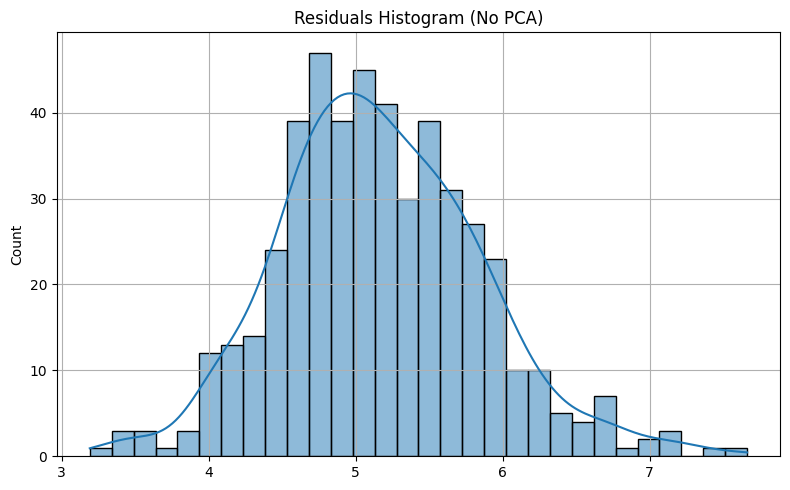

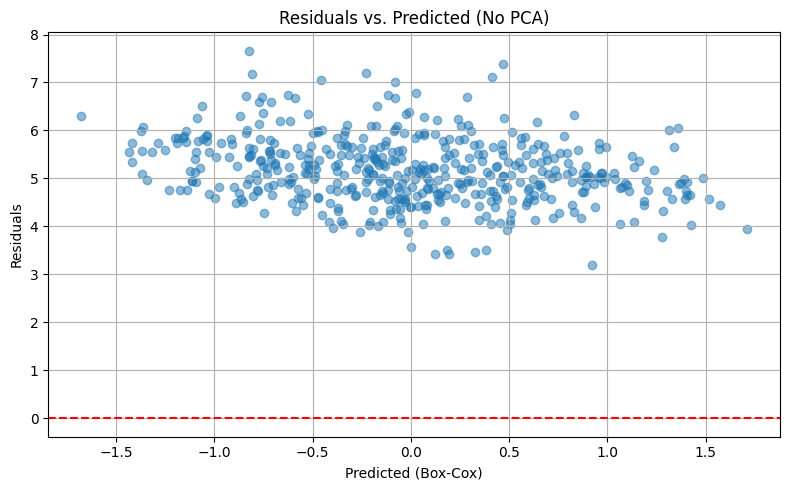

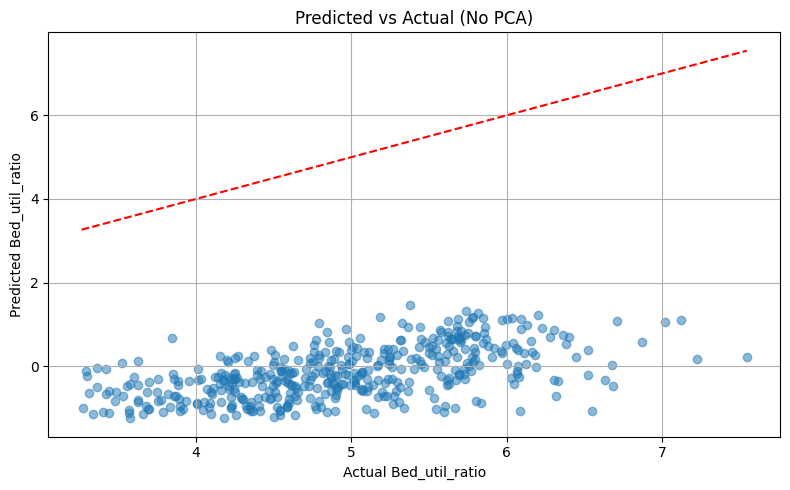


Final RMSE (Original Scale, No PCA): 5.1531
Dropped 40 NaN predictions from inverse Box-Cox.

Final RMSE (Original Scale, No PCA): 5.1531


In [28]:
"""
This cell fits a second Support Vector Regression (SVR) model
using the full set of scaled input features (without PCA-based dimensionality reduction).

Purpose:
- To serve as a benchmark and comparison against the SVM model trained on PCA-reduced features
- To assess whether dimensionality reduction via PCA improves, worsens,
or has minimal effect on prediction accuracy

Inputs:
- X_train_scaled, X_test_scaled: Scaled full feature matrices (23 original features,
no dimensionality reduction)
- y_train_bc, y_test_bc: Target variable (Bed_util_ratio), transformed using Box-Cox
to improve normality and stabilize variance

This model:
- Trains an SVR model using the full input space (no PCA)
- Uses 5-fold cross-validation to evaluate training performance (R²)
- Predicts on the Box-Cox transformed test set
- Computes evaluation metrics: RMSE, MAE, and R² on Box-Cox scale
- Performs residual diagnostics:
    - Shapiro-Wilk normality test
    - Histogram and residual scatter plot
- Applies inverse Box-Cox transformation to return predictions to their original scale
- Computes final RMSE in original units and visualizes predicted vs. actual target values
- Handles NaNs resulting from inverse transformation for clean metric reporting

Note:
This section allows side-by-side performance comparison with the PCA-based SVM pipeline
to assess the impact of dimensionality reduction.
"""

# --- SVM Without PCA (on full scaled features) ---

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.special import inv_boxcox
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

# Fit SVM
svm_raw = SVR(kernel='rbf', C=1.0, epsilon=0.1)
cv_raw = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_raw = cross_val_score(svm_raw, X_train_scaled, y_train_bc, cv=cv_raw, scoring='r2')

svm_raw.fit(X_train_scaled, y_train_bc)
y_pred_raw_bc = svm_raw.predict(X_test_scaled)

# Evaluate
rmse_raw = np.sqrt(mean_squared_error(y_test_bc, y_pred_raw_bc))
mae_raw = mean_absolute_error(y_test_bc, y_pred_raw_bc)
r2_raw = r2_score(y_test_bc, y_pred_raw_bc)
print(f"CV R² (no PCA): {cv_scores_raw.mean():.4f} ± {cv_scores_raw.std():.4f}")
print(f"Test RMSE: {rmse_raw:.4f}")
print(f"Test MAE:  {mae_raw:.4f}")
print(f"Test R²:   {r2_raw:.4f}")

# Residuals Diagnostics
residuals_raw = y_test_bc - y_pred_raw_bc
stat_raw, p_raw = shapiro(residuals_raw)
print(f"\nShapiro-Wilk (No PCA): W = {stat_raw:.4f}, p = {p_raw:.4f}")
print("Likely Normal" if p_raw > 0.05 else "Not Normal\n")

# Residuals Plot
plt.figure(figsize=(8, 5))
sns.histplot(residuals_raw, kde=True, bins=30)
plt.title("Residuals Histogram (No PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_raw_bc, residuals_raw, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted (No PCA)")
plt.xlabel("Predicted (Box-Cox)")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# Inverse Transform for Interpretation
y_pred_raw_orig = inv_boxcox(y_pred_raw_bc, lambda_bc) - shift_amount
y_test_orig = inv_boxcox(y_test_bc, lambda_bc) - shift_amount

plt.figure(figsize=(8, 5))
plt.scatter(y_test_orig, y_pred_raw_orig, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()],
         [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("Actual Bed_util_ratio")
plt.ylabel("Predicted Bed_util_ratio")
plt.title("Predicted vs Actual (No PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()

valid_mask_raw = ~np.isnan(y_pred_raw_orig)
rmse_raw_orig = np.sqrt(mean_squared_error(y_test_orig[valid_mask_raw], y_pred_raw_orig[valid_mask_raw]))

print(f"\nFinal RMSE (Original Scale, No PCA): {rmse_raw_orig:.4f}")
print(f"Dropped {np.isnan(y_pred_raw_orig).sum()} NaN predictions from inverse Box-Cox.")
print(f"\nFinal RMSE (Original Scale, No PCA): {rmse_raw_orig:.4f}")


In [29]:
print("NaNs in y_pred_raw_orig:", np.isnan(y_pred_raw_orig).sum())


NaNs in y_pred_raw_orig: 40


# View - Top Predicters for PC1 only

In [30]:
"""
This cell analyzes the contribution of original features to the first 10 principal components generated by PCA.

Purpose:
- To interpret what the principal components represent in terms of the original features
- To identify which features most strongly influence each component, especially PC1

Steps performed:
- Converts the PCA-transformed NumPy array (X_train_scaled) into a labeled DataFrame using the original feature names
- Constructs a PCA loadings matrix ('loadings_df'), where:
    - Rows = Principal Components (PC1–PC10)
    - Columns = Original features
    - Cell values = correlation-like weights (loadings) showing each feature's contribution to that component
- Extracts and displays the top 10 most influential features (by absolute loading value) for the first principal component (PC1)

Interpretation:
- Features with the highest absolute loadings for PC1 are the strongest contributors to the variance captured by that component.
- This allows labeling PCs (e.g., "Urban Density and Access Barriers") and drawing real-world conclusions from otherwise abstract components.
"""

# Extract original column names from X_train before scaling
original_feature_names = X_train.columns

# Adding Column names to:
X_scaled_df = pd.DataFrame(X_train_scaled, columns=original_feature_names)

# Create loadings DataFrame (rows = PCs, cols = original features)
loadings_df = pd.DataFrame(
    pca.components_[:10],  # first 10 components
    columns=X_scaled_df.columns,
    index=[f"PC{i+1}" for i in range(10)]
)

# Show top contributing features to PC1
top_pc1 = loadings_df.loc["PC1"].abs().sort_values(ascending=False)
print("Top contributing features to PC1:")
print(top_pc1.head(10))


Top contributing features to PC1:
Population_density          0.331302
Pct_public_transit          0.283473
Is_Metro_Micro              0.269979
Median_hh_income            0.262806
Total_population_poverty    0.255056
Pct_renter_occupied         0.249445
Pct_hh_65_alone             0.245546
Pct_age_65plus              0.235385
Pct_hh_no_internet          0.235118
Distance_to_medsurge_icu    0.234842
Name: PC1, dtype: float64


# View - Top Predicters for Top 5 Principle Components only

In [31]:
"""
Displays the top 5 contributing original features for each of the first 10 principal components.
Helps interpret what each PC represents in terms of feature influence.
"""

# See top 5 features for each PC (1–5)
for i in range(10):
    pc = f"PC{i+1}"
    top_features = loadings_df.loc[pc].abs().sort_values(ascending=False).head(5)
    print(f"\nTop features in {pc}:")
    print(top_features)



Top features in PC1:
Population_density          0.331302
Pct_public_transit          0.283473
Is_Metro_Micro              0.269979
Median_hh_income            0.262806
Total_population_poverty    0.255056
Name: PC1, dtype: float64

Top features in PC2:
Pct_single_parent             0.388710
Median_hh_income              0.315272
Pct_homes_no_vehicle          0.314837
Pct_disabled                  0.306268
Pct_renter_cost_50pct_plus    0.299316
Name: PC2, dtype: float64

Top features in PC3:
Pct_age_65plus           0.363676
Pct_owner_cost_30plus    0.337252
Region_West              0.325858
Pct_hh_65_alone          0.320916
Land_area_sqmi           0.314795
Name: PC3, dtype: float64

Top features in PC4:
Pct_homes_no_vehicle          0.344524
state_encoded                 0.325466
Pct_renter_occupied           0.299026
Population_density            0.298033
Pct_renter_cost_30pct_plus    0.293317
Name: PC4, dtype: float64

Top features in PC5:
Region_West         0.528836
Region_North

# Start a Random Forest Model From X_train_scaled - Regression Model

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

rf = RandomForestRegressor(n_estimators=100, random_state= 42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest - R²: {r2:.4f}, RMSE: {rmse:.4f}")

Random Forest - R²: -38.3942, RMSE: 1.0881


In [33]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost - R²: {r2:.4f}, RMSE: {rmse:.4f}")


XGBoost - R²: -38.5357, RMSE: 1.0901


In [34]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost - R²: {r2:.4f}, RMSE: {rmse:.4f}")


XGBoost - R²: -38.5357, RMSE: 1.0901


# Converted Target to binary (Bed_Util_Ratio >0.5 = 1 else 0)

# Target Distribution Visualization (Bed_util_ratio)

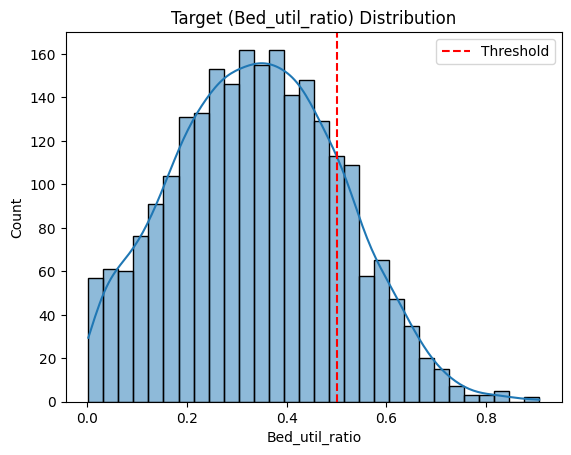

In [35]:
"""
This cell visualizes the distribution of the original target variable 'Bed_util_ratio'.
A vertical red line marks the threshold of 0.5 used for binary classification.
This plot helps assess class imbalance and validate the choice of threshold.
"""

import matplotlib.pyplot as plt
sns.histplot(y, bins=30, kde=True)
plt.axvline(0.5, color='red', linestyle='--', label='Threshold')
plt.title("Target (Bed_util_ratio) Distribution")
plt.legend()
plt.show()

# Binary Classification Setup – Stratified Train-Test Split

In [36]:
"""
This cell prepares the binary classification target by thresholding 'Bed_util_ratio' at 0.5.
It then performs a stratified train-test split to ensure class proportions are preserved in both sets.

The binary label:
- 0 → Bed_util_ratio ≤ 0.5 (low utilization)
- 1 → Bed_util_ratio > 0.5 (high utilization)
"""
from sklearn.model_selection import train_test_split
import pandas as pd

# Convert regression target into binary (threshold = 0.5)
y_bin = (y > 0.5).astype(int)

# Stratified train-test split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_scaled, y_bin, test_size=0.2, stratify=y_bin, random_state=42
)

# Check balance
print("Train class distribution:\n", pd.Series(y_train_bin).value_counts(normalize=True))
print("Test class distribution:\n", pd.Series(y_test_bin).value_counts(normalize=True))


Train class distribution:
 Bed_util_ratio
0    0.823222
1    0.176778
Name: proportion, dtype: float64
Test class distribution:
 Bed_util_ratio
0    0.822547
1    0.177453
Name: proportion, dtype: float64


# Random Forest

# Random Forest Classification – Initial Evaluation (No Cross-Validation)

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90       394
           1       0.53      0.28      0.37        85

    accuracy                           0.83       479
   macro avg       0.70      0.61      0.64       479
weighted avg       0.80      0.83      0.81       479

ROC AUC Score: 0.7934458047178264


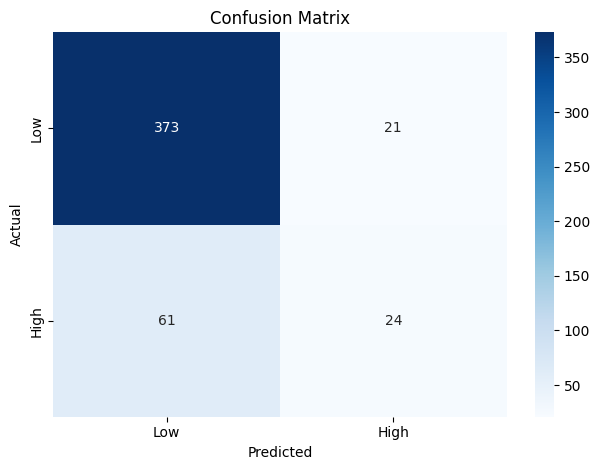

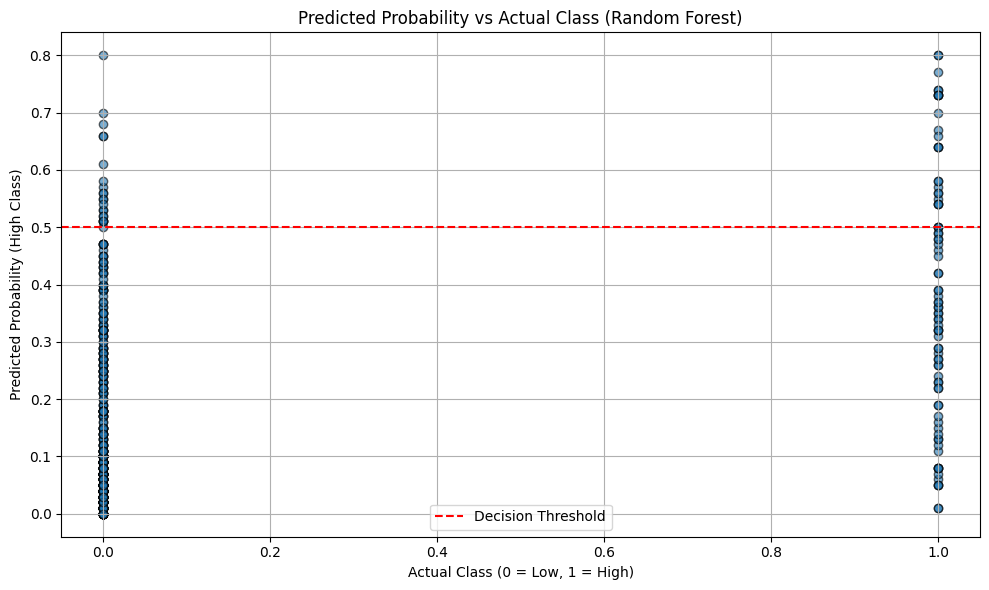

In [37]:
"""
This cell fits a Random Forest Classifier to predict high vs. low hospital bed utilization.

Inputs:
- X_train_bin, X_test_bin: features from the stratified binary classification split
- y_train_bin, y_test_bin: binary labels (0 = low, 1 = high)

Evaluation Metrics:
- Confusion matrix visualization
- Classification report (precision, recall, F1-score)
- ROC AUC score

Plot:
- Predicted Probability vs Actual Class (Random Forest Classifier)
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_bin, y_train_bin)

# Predict
y_pred = clf.predict(X_test_bin)
y_proba = clf.predict_proba(X_test_bin)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test_bin, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test_bin, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(y_test_bin, y_proba, alpha=0.6, edgecolor='k')
plt.axhline(0.5, color='red', linestyle='--', label='Decision Threshold')
plt.xlabel("Actual Class (0 = Low, 1 = High)")
plt.ylabel("Predicted Probability (High Class)")
plt.title("Predicted Probability vs Actual Class (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Random Forest with Class Weighting - Full Feature Set (No PCA)

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91       394
           1       0.60      0.32      0.42        85

    accuracy                           0.84       479
   macro avg       0.73      0.64      0.66       479
weighted avg       0.82      0.84      0.82       479

ROC AUC Score: 0.8074201254105703


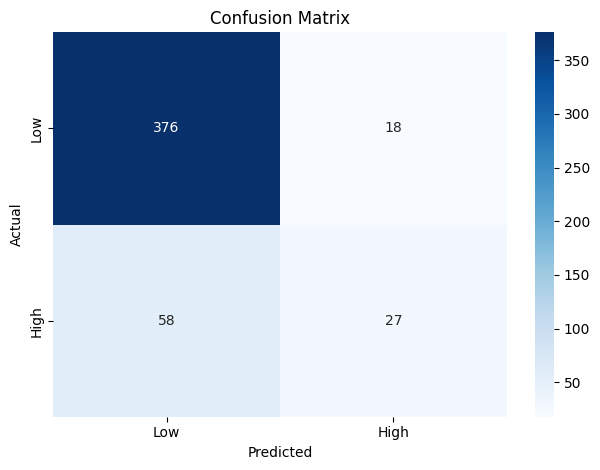

In [38]:
"""
This cell trains a Random Forest Classifier using class weighting ('class_weight='balanced'')
to mitigate class imbalance.

Inputs:
- X_train_bin, X_test_bin: binary-class features (already scaled)
- y_train_bin, y_test_bin: binary target labels based on Bed_util_ratio threshold

Key Enhancements:
- Adjusts for class imbalance by giving higher weight to underrepresented class
- Outputs classification metrics and a confusion matrix
- Calculates ROC AUC to assess overall class separation
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
clf_full = RandomForestClassifier(n_estimators=100, class_weight= 'balanced', random_state=42)
clf_full.fit(X_train_bin, y_train_bin)

# Predict
y_pred = clf_full.predict(X_test_bin)
y_proba = clf_full.predict_proba(X_test_bin)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test_bin, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test_bin, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Cross-Validated Random Forest (ROC AUC Evaluation with Class Weighting - No PCA)

Cross-Validated ROC AUC Scores: [0.57089169 0.47299253 0.54477612 0.50987918 0.44213657]
Mean ROC AUC: 0.5081 ± 0.0466

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90       394
           1       0.00      0.00      0.00        85

    accuracy                           0.82       479
   macro avg       0.41      0.50      0.45       479
weighted avg       0.68      0.82      0.74       479

Test ROC AUC Score: 0.4773514481934907


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


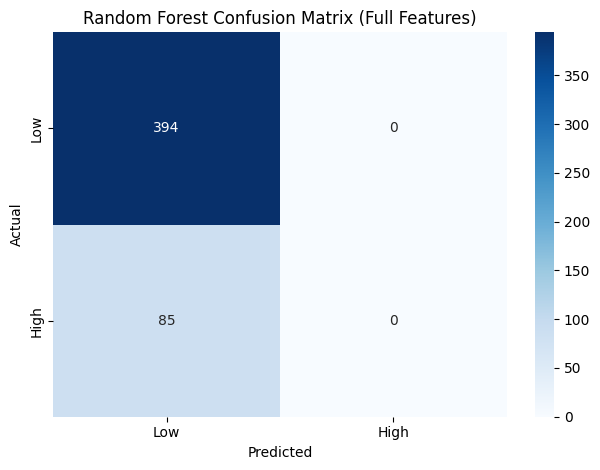

In [39]:
"""
This cell applies Stratified K-Fold Cross-Validation to evaluate Random Forest
performance on imbalanced binary classification.

Inputs:
- X_train_scaled: full scaled training features
- y_train_bin: binary classification labels

Key Parameters:
- RandomForestClassifier with 'class_weight='balanced'' to correct for class imbalance
- StratifiedKFold ensures class distribution remains consistent across folds
- ROC AUC used as scoring metric to evaluate class separation capability

Output:
- ROC AUC scores across 5 folds
- Mean and standard deviation of performance
"""

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create classifier
clf_full = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Define stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate using ROC AUC (or try 'f1_macro' for balance)
cv_scores = cross_val_score(clf_full, X_train_scaled, y_train_bin, cv=skf, scoring='roc_auc')

print("Cross-Validated ROC AUC Scores:", cv_scores)
print(f"Mean ROC AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Fit model
clf_full.fit(X_train_scaled, y_train_bin)

# Predict on test set
y_pred = clf_full.predict(X_test_scaled)
y_proba = clf_full.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\nClassification Report:\n", classification_report(y_test_bin, y_pred))
print("Test ROC AUC Score:", roc_auc_score(y_test_bin, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test_bin, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix (Full Features)")
plt.tight_layout()
plt.show()


# Random Forest Classification Using PCA-Transformed Features (ROC AUC Evaluation with Class Weighting)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.82      1.00      0.90       394
           1       0.00      0.00      0.00        85

    accuracy                           0.82       479
   macro avg       0.41      0.50      0.45       479
weighted avg       0.68      0.82      0.74       479

ROC AUC Score: 0.46516870707673935


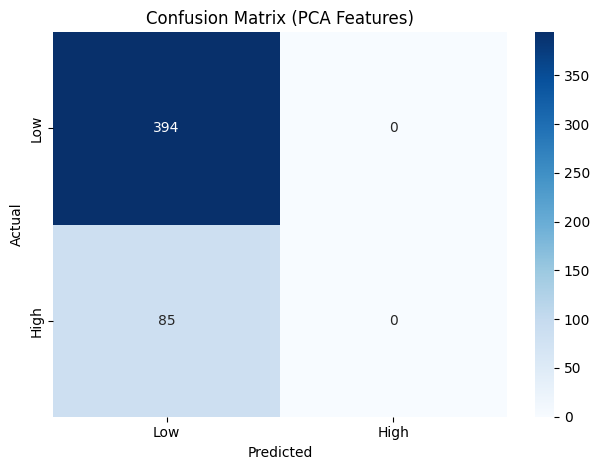

In [40]:
"""
This cell fits a Random Forest Classifier using PCA-reduced features (X_train_pca, X_test_pca)
to predict binary hospital bed utilization.

Target:
- y_train_bin, y_test_bin (1 = high utilization, 0 = low)

Evaluation:
- Classification report
- Confusion matrix
- ROC AUC
"""

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train model on PCA features
clf_pca = RandomForestClassifier(n_estimators= 100, class_weight= 'balanced', random_state= 42)
clf_pca.fit(X_train_pca, y_train_bin)

# Predict
y_pred_pca = clf_pca.predict(X_test_pca)
y_proba_pca = clf_pca.predict_proba(X_test_pca)[:,1]

# Evaluation
print('Classification Report: \n', classification_report(y_test_bin, y_pred_pca))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_proba_pca))

# Confusion Matrix
cm_pca = confusion_matrix(y_test_bin, y_pred_pca)
sns.heatmap(cm_pca, annot = True, fmt= 'd', cmap = 'Blues', xticklabels= ['Low', 'High'], yticklabels= ['Low', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (PCA Features)")
plt.tight_layout()
plt.show()

#  Random Forest - PCA Features + Cross-Validation

CV AUC: 0.5208455388049316


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report: 
               precision    recall  f1-score   support

           0       0.82      1.00      0.90       394
           1       0.00      0.00      0.00        85

    accuracy                           0.82       479
   macro avg       0.41      0.50      0.45       479
weighted avg       0.68      0.82      0.74       479

ROC AUC Score: 0.46516870707673935


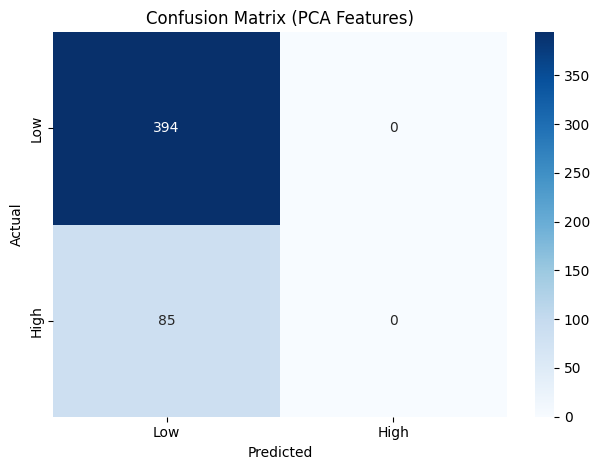

In [41]:
"""
This cell applies Stratified K-Fold Cross-Validation and fits a Random Forest Classifier using PCA-reduced features (X_train_pca, X_test_pca)
to predict binary hospital bed utilization.

Target:
- y_train_bin, y_test_bin (1 = high utilization, 0 = low)

Evaluation:
- Classification report
- Confusion matrix
- Cross-validated ROC AUC
"""

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train model on PCA features
clf_pca = RandomForestClassifier(n_estimators= 100, class_weight= 'balanced', random_state= 42)


# Define model
clf_pca = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Cross-validation
cv_score = cross_val_score(clf_pca, X_train_pca, y_train_bin, cv=skf, scoring='roc_auc')
print("CV AUC:", cv_score.mean())

# Now fit for final test prediction
clf_pca.fit(X_train_pca, y_train_bin)

# Predict and evaluate
y_pred_pca = clf_pca.predict(X_test_pca)
y_proba_pca = clf_pca.predict_proba(X_test_pca)[:,1]

# Evaluation
print('Classification Report: \n', classification_report(y_test_bin, y_pred_pca))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_proba_pca))

# Confusion Matrix
cm_pca = confusion_matrix(y_test_bin, y_pred_pca)
sns.heatmap(cm_pca, annot = True, fmt= 'd', cmap = 'Blues', xticklabels= ['Low', 'High'], yticklabels= ['Low', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (PCA Features)")
plt.tight_layout()
# plt.show()

## SVM

# SVM Classifier on Full Scaled Features (No PCA)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.59      0.68       394
           1       0.17      0.39      0.24        85

    accuracy                           0.55       479
   macro avg       0.49      0.49      0.46       479
weighted avg       0.70      0.55      0.60       479

ROC AUC Score: 0.49519259480441924


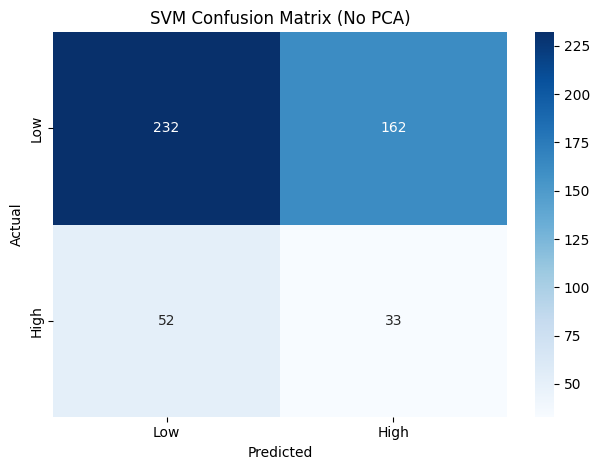

In [42]:
# SVM Classifier on Full Scaled Features (No PCA)

"""
This cell fits a Support Vector Classifier (SVC) using the full scaled feature set (X_train_scaled, X_test_scaled)
to predict binary hospital bed utilization (high vs. low).

Inputs:
- X_train_scaled, X_test_scaled: full scaled feature sets (no PCA)
- y_train_bin, y_test_bin: binary classification labels

Evaluation includes:
- Classification report
- ROC AUC
- Confusion matrix
"""

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define and train the model
svm_full = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_full.fit(X_train_scaled, y_train_bin)

# Predict
y_pred_full = svm_full.predict(X_test_scaled)
y_proba_full = svm_full.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test_bin, y_pred_full))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_proba_full))

# Confusion Matrix
cm = confusion_matrix(y_test_bin, y_pred_full)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix (No PCA)")
plt.tight_layout()
plt.show()


# Support Vector Classifier (SVC) on PCA Features – Binary Classification

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.62      0.70       394
           1       0.16      0.34      0.22        85

    accuracy                           0.57       479
   macro avg       0.49      0.48      0.46       479
weighted avg       0.70      0.57      0.62       479

ROC AUC Score: 0.4728575694237086


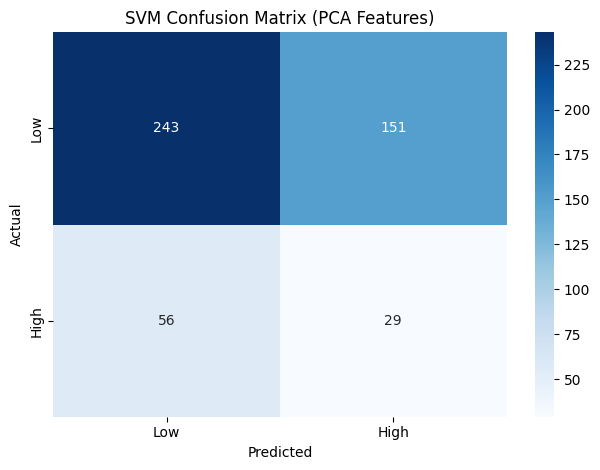

In [43]:
# SVM Classifier with PCA-Reduced Features (Binary Classification)

"""
This cell fits a Support Vector Classifier (SVC) on PCA-reduced features to predict binary hospital bed utilization.

Inputs:
- X_train_pca, X_test_pca: PCA-reduced features (continuous)
- y_train_bin, y_test_bin: Binary classification labels

Evaluation includes:
- Classification Report
- ROC AUC
- Confusion Matrix
"""

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Fit SVM model
svm_pca = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_pca.fit(X_train_pca, y_train_bin)

# Predict
y_pred_svm_pca = svm_pca.predict(X_test_pca)
y_proba_svm_pca = svm_pca.predict_proba(X_test_pca)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test_bin, y_pred_svm_pca))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_proba_svm_pca))

# Confusion Matrix
cm_svm_pca = confusion_matrix(y_test_bin, y_pred_svm_pca)
sns.heatmap(cm_svm_pca, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix (PCA Features)")
plt.tight_layout()
plt.show()


# SVM Classifier on PCA Features (with Cross-Validation)

Cross-Validated ROC AUC Scores: [0.54052288 0.48412698 0.51855011 0.52561005 0.49035219]
Mean ROC AUC: 0.5118 ± 0.0214

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.62      0.70       394
           1       0.16      0.34      0.22        85

    accuracy                           0.57       479
   macro avg       0.49      0.48      0.46       479
weighted avg       0.70      0.57      0.62       479

Test ROC AUC Score: 0.4728575694237086


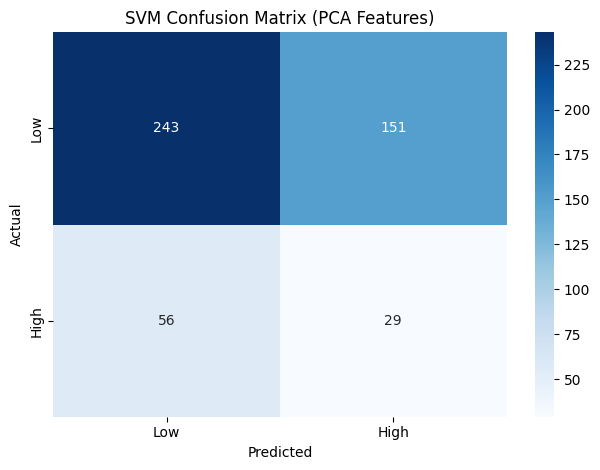

In [44]:
"""
This cell fits a Support Vector Classifier (SVC) on PCA-reduced features to predict binary hospital bed utilization.

Inputs:
- X_train_pca, X_test_pca: PCA-reduced features (continuous)
- y_train_bin, y_test_bin: Binary classification labels (0 = low, 1 = high utilization)

Evaluation includes:
- Cross-validated ROC AUC score using Stratified K-Fold (n=5)
- Final Classification Report on test set
- Confusion Matrix
- ROC AUC on test set
"""

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define SVM classifier
svm_pca = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)

# Cross-validation setup (on training data only)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_pca, X_train_pca, y_train_bin, cv=skf, scoring='roc_auc')

# Print cross-validation results
print("Cross-Validated ROC AUC Scores:", cv_scores)
print(f"Mean ROC AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Fit on full training set
svm_pca.fit(X_train_pca, y_train_bin)

# Predict on test set
y_pred_svm_pca = svm_pca.predict(X_test_pca)
y_proba_svm_pca = svm_pca.predict_proba(X_test_pca)[:, 1]

# Evaluate on test set
print("\nClassification Report:\n", classification_report(y_test_bin, y_pred_svm_pca))
print("Test ROC AUC Score:", roc_auc_score(y_test_bin, y_proba_svm_pca))

# Confusion Matrix
cm_svm_pca = confusion_matrix(y_test_bin, y_pred_svm_pca)
sns.heatmap(cm_svm_pca, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix (PCA Features)")
plt.tight_layout()
plt.show()


# Logistic Regression - No PCA - No CCV

In [45]:
"""
Fits a logistic regression model on the full scaled feature set to classify hospital bed utilization (high vs. low).
Class imbalance is addressed using balanced class weights. Evaluation includes ROC AUC and a classification report
to summarize precision, recall, and F1-score.
"""

from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_clf.fit(X_train_scaled, y_train_bin)

y_pred_log = log_clf.predict(X_test_scaled)
y_proba_log = log_clf.predict_proba(X_test_scaled)[:, 1]

print("ROC AUC:", roc_auc_score(y_test_bin, y_proba_log))
print(classification_report(y_test_bin, y_pred_log))


ROC AUC: 0.5063899671543745
              precision    recall  f1-score   support

           0       0.83      0.50      0.63       394
           1       0.19      0.54      0.28        85

    accuracy                           0.51       479
   macro avg       0.51      0.52      0.45       479
weighted avg       0.72      0.51      0.56       479



# Logistic Regression with PCA-Reduced Features (Binary Target)

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.49      0.61       394
           1       0.15      0.41      0.22        85

    accuracy                           0.48       479
   macro avg       0.47      0.45      0.41       479
weighted avg       0.68      0.48      0.54       479

ROC AUC Score: 0.46649746192893404


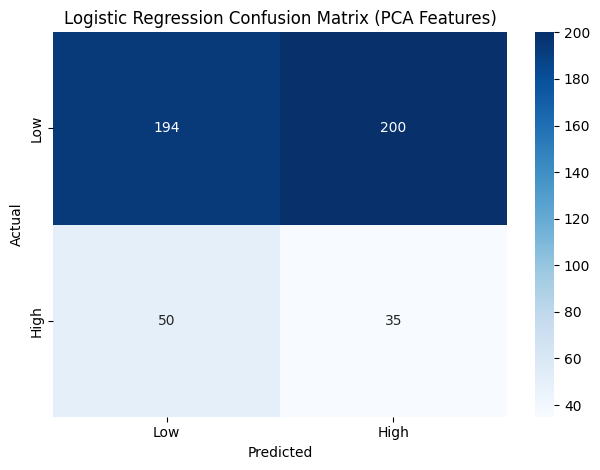

In [46]:
"""
This cell fits a Logistic Regression classifier on PCA-reduced features to predict
binary hospital bed utilization (1 = high, 0 = low).

Inputs:
- X_train_pca, X_test_pca: PCA-reduced features
- y_train_bin, y_test_bin: binary classification target

Evaluation:
- Classification report
- ROC AUC score
- Confusion matrix
"""

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Fit Logistic Regression
log_pca = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_pca.fit(X_train_pca, y_train_bin)

# Predict
y_pred_pca = log_pca.predict(X_test_pca)
y_proba_pca = log_pca.predict_proba(X_test_pca)[:, 1]

# Evaluate
print("Classification Report:\n", classification_report(y_test_bin, y_pred_pca))
print("ROC AUC Score:", roc_auc_score(y_test_bin, y_proba_pca))

# Confusion Matrix
cm = confusion_matrix(y_test_bin, y_pred_pca)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix (PCA Features)")
plt.tight_layout()
plt.show()
